# Buy/Not buy action predicted using LSTM

This notebook utilised LSTM to predict the buy or not buy action of a stock. The feature of the stock is the Open, High, Low, Close, Volume, Adj Close price of the stock. The target is the action of the stock, which is 1 if the stock price is higher than the previous day, and 0 if the stock price is lower than the previous day.

In [1]:
# import library for Support Vector Classification
from sklearn.svm import SVC

# import library for plot
import matplotlib.pyplot as plt

# import library for data handling
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import math

# import library for pytorch
import torch
import torch.nn as nn

# import custom function
from LSTM_stock_predict import SequenceDataset, ShallowRegressionLSTM, train, test, get_stock_data, split_train_test, predict_binary, split_train_test_binary
from SVC_stock_predict import svc_train

# Get cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/victoru/anaconda3/envs/testpython/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Get the past stock price
df = get_stock_data(stock_name = 'AAPL', source = 'yahoo', past_year = 1)

In [3]:
features = df.columns

In [4]:
features

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

In [5]:
# set up train and test data
train_df, test_df, train_size, test_size, df['perfect'] = split_train_test_binary(df,0.7)


In [6]:
# create dataset and dataloader
batch_size = 5
seq_len = 20

torch.manual_seed(seq_len*batch_size/2)

train_dataset = SequenceDataset(train_df, 'perfect', features, seq_len)
test_dataset = SequenceDataset(test_df, 'perfect', features, seq_len)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# get the first batch of data to check the shape
x, y = next(iter(train_loader))
print("Feature shape: ", x.shape)
print("Target shape: ", y.shape)

Feature shape:  torch.Size([5, 20, 6])
Target shape:  torch.Size([5])


In [7]:
# create model, loss and optimizer
learning_rate = 5e-5
num_hidden = 8
num_layers = 1
epoch = 100

model = ShallowRegressionLSTM(n_features = len(features), n_hidden = num_hidden, n_layers = num_layers, device = device).to(device)
loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
# train and test
print("Untrained test")
test(model, test_loader, loss, device)

print("Training")
for i in range(epoch):
    print("Epoch: " + str(i+1))
    train(model, train_loader, loss, optimizer, device)
    test(model, test_loader, loss, device)



Untrained test
Test loss: 0.6799
Training
Epoch: 1
Train loss: 0.7020
Test loss: 0.6798
Epoch: 2
Train loss: 0.7019
Test loss: 0.6797
Epoch: 3
Train loss: 0.6945
Test loss: 0.6796
Epoch: 4
Train loss: 0.7016
Test loss: 0.6795
Epoch: 5
Train loss: 0.6976
Test loss: 0.6794
Epoch: 6
Train loss: 0.6955
Test loss: 0.6793
Epoch: 7
Train loss: 0.7008
Test loss: 0.6792
Epoch: 8
Train loss: 0.6972
Test loss: 0.6791
Epoch: 9
Train loss: 0.6929
Test loss: 0.6789
Epoch: 10
Train loss: 0.7006
Test loss: 0.6788
Epoch: 11
Train loss: 0.6945
Test loss: 0.6787
Epoch: 12
Train loss: 0.6987
Test loss: 0.6786
Epoch: 13
Train loss: 0.6925
Test loss: 0.6786
Epoch: 14
Train loss: 0.6995
Test loss: 0.6785
Epoch: 15
Train loss: 0.6947
Test loss: 0.6784
Epoch: 16
Train loss: 0.6986
Test loss: 0.6783
Epoch: 17
Train loss: 0.6979
Test loss: 0.6782
Epoch: 18
Train loss: 0.6942
Test loss: 0.6782
Epoch: 19
Train loss: 0.6910
Test loss: 0.6782
Epoch: 20
Train loss: 0.6914
Test loss: 0.6781
Epoch: 21
Train loss: 0.698

In [9]:
# make prediction
train_eval = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

train_df["pred_action"] = predict_binary(train_eval, model, device)
test_df["pred_action"] = predict_binary(test_loader, model, device)

df['pred_action'] = pd.concat([train_df, test_df], axis=0)['pred_action']

In [10]:
# make random decision
df["random_action"] = np.random.randint(0,2,df.shape[0])

print(df['random_action'])

Date
2021-10-01    0
2021-10-04    0
2021-10-05    0
2021-10-06    0
2021-10-07    0
             ..
2022-09-26    1
2022-09-27    1
2022-09-28    1
2022-09-29    1
2022-09-30    1
Name: random_action, Length: 252, dtype: int64


In [11]:
# Calculate the daily returns from the stock
df['returns'] = df['Close'].pct_change(1)
# Show the returns
df['returns']

Date
2021-10-01         NaN
2021-10-04   -0.024606
2021-10-05    0.014158
2021-10-06    0.006307
2021-10-07    0.009084
                ...   
2022-09-26    0.002260
2022-09-27    0.006566
2022-09-28   -0.012652
2022-09-29   -0.049119
2022-09-30   -0.030039
Name: returns, Length: 252, dtype: float64

In [12]:
# Calculate the strategy returns
df['strategy_returns'] = df['pred_action'].shift(1) * df['returns']
# Show the strategy returns
df['strategy_returns']

Date
2021-10-01         NaN
2021-10-04   -0.024606
2021-10-05    0.014158
2021-10-06    0.006307
2021-10-07    0.009084
                ...   
2022-09-26    0.002260
2022-09-27    0.006566
2022-09-28   -0.012652
2022-09-29   -0.049119
2022-09-30   -0.030039
Name: strategy_returns, Length: 252, dtype: float64

In [13]:
# Calculate the cumulative strategy returns
df['cum_strategy_returns'] = df['strategy_returns'].cumsum()
# Show the cumulative strategy returns
df['cum_strategy_returns']

Date
2021-10-01         NaN
2021-10-04   -0.024606
2021-10-05   -0.010447
2021-10-06   -0.004140
2021-10-07    0.004944
                ...   
2022-09-26    0.306700
2022-09-27    0.313266
2022-09-28    0.300614
2022-09-29    0.251495
2022-09-30    0.221456
Name: cum_strategy_returns, Length: 252, dtype: float64

In [14]:
# Calculate the random returns
df['random_returns'] = df['random_action'].shift(1) * df['returns']
# Calculate the cumulative random returns
df['cum_random_returns'] = df['random_returns'].cumsum()


In [15]:
# Calculate the perfect returns
df['perfect_returns'] = df['perfect'].shift(1) * df['returns']
# Calculate the cumulative perfect returns
df['cum_perfect_returns'] = df['perfect_returns'].cumsum()

In [16]:
# train svc model
svc_model,df['High-Low'],df['Open-Close'] = svc_train(df)

df['svc_action'] = svc_model.predict(df[['Open-Close', 'High-Low']])

In [17]:
# Calculate the svc returns
df['svc_returns'] = df['svc_action'].shift(1) * df['returns']
# Calculate the cumulative svc returns
df['cum_svc_returns'] = df['svc_returns'].cumsum()

In [18]:
# Calculate market returns
df['market_returns'] = df['returns'].cumsum()

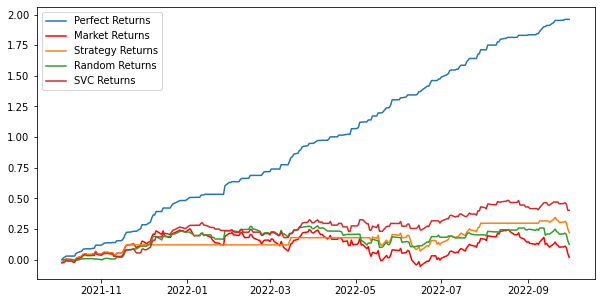

In [19]:
# plot returns
plt.figure(figsize=(10,5))
plt.plot(df['cum_perfect_returns'], label='Perfect Returns')
plt.plot(df['market_returns'], color='r', label='Market Returns')
plt.plot(df['cum_strategy_returns'], label='Strategy Returns')
plt.plot(df['cum_random_returns'], label='Random Returns')
plt.plot(df['cum_svc_returns'], label='SVC Returns')
plt.legend()
plt.show()